In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import zipfile
import os
import warnings

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [4]:
def plot_image_from_list(__data, __preds, __labels, __count=(5, 5), __channels=3, __random_state=10):
    plt.figure(figsize=(10, 10))
    for _i in range(__count[0] * __count[1]):
        plt.subplot(__count[0], __count[1], _i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False) 
        _img = (__data[_i].squeeze() if __channels==1 else __data[_i].permute(1, 2, 0)).to("cpu").numpy()
        plt.imshow(_img, cmap= "gray" if __channels == 1 else None)
        plt.xlabel(__labels[__preds[_i]])
    plt.show()

In [5]:
def plot_image_from_dataset(__dataset, __count=(5, 5), __channels=3, __random_state=10):
    torch.manual_seed(__random_state)
    plt.figure(figsize=(10, 10))
    _rand_idices = torch.randint(len(__dataset), (__count[0] * __count[1],)).tolist()
    _data = [__dataset[_i][0] for _i in _rand_idices]
    _preds = [__dataset[_i][1] for _i in _rand_idices]
    _labels = __dataset.classes
    plot_image_from_list(_data, _preds, _labels, __count, __channels, __random_state)
    plt.show()

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_file, train=True):
        # extract the data.zip file
        if not os.path.exists("./tmp2/data"):
            os.makedirs("./tmp2/data")

        with zipfile.ZipFile(data_file, 'r') as zip_ref:
            zip_ref.extractall("./tmp2/data")

        # load the data
        self.train_X = np.load(f"./tmp2/data/a_{'r' if train else 's'}.npy")
        self.train_y = np.load(f"./tmp2/data/b_{'r' if train else 's'}.npy")
        self.classes = np.load(f"./tmp2/data/c_{'r' if train else 's'}.npy")
        

    def __len__(self):
        return self.train_X.shape[0]

    def __getitem__(self, idx):
        _x = torch.from_numpy(self.train_X[idx])
        _y = self.train_y[idx]
        return (_x, _y)


In [7]:
# Set the path to data.zip file here
path_to_data = "./tmp/data.zip"

In [8]:
dataset_train = CustomDataset(path_to_data, train=True)

<Figure size 720x720 with 0 Axes>

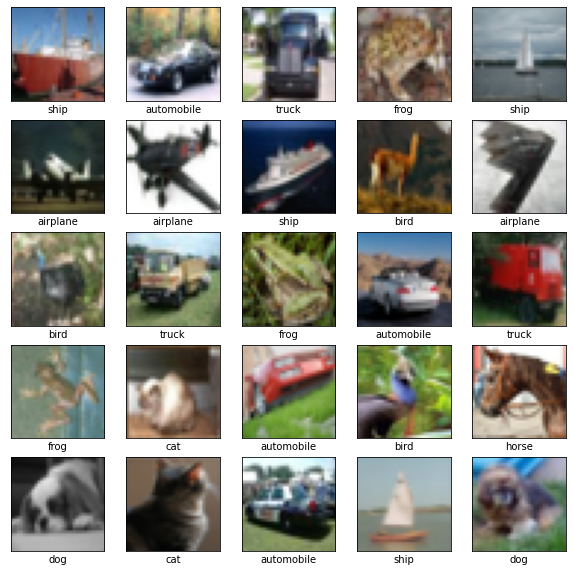

In [9]:
plot_image_from_dataset(dataset_train)

In [10]:
from torch.utils.data import DataLoader
# Define a DataLoader to get training data (X and y)
batch_size = 32  # You can set this to the desired batch size
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Iterate through the DataLoader to get training data
for batch in train_loader:
    batch_x, batch_y = batch


In [16]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)  # Reshape for fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [15]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Adjust the dimensions to match the output of the second convolutional layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
# Define the number of classes in your dataset
num_classes = len(dataset_train.classes)

# Instantiate the model
model = CustomCNN(num_classes)

# Define the input image dimensions of your dataset
input_channels = 3  # Change this to match your dataset's input channels (e.g., 1 for grayscale)
input_height = 32   # Change this to match your dataset's image height
input_width = 32    # Change this to match your dataset's image width

# Modify the first convolutional layer to match the input dimensions
model.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)

# Modify the fully connected layers to match the number of classes
model.fc1 = nn.Linear(64 * (input_height // 4) * (input_width // 4), 128)
model.fc2 = nn.Linear(128, num_classes)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the number of training epochs
num_epochs = 25 # Adjust this as needed


In [14]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device, dtype=torch.long)  # Convert labels to torch.long

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and print the average loss for this epoch
    average_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x16384 and 4096x128)

In [16]:
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in train_loader:  # Assuming train_loader is your DataLoader for the training data
        inputs, labels = batch
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = 100 * total_correct / total_samples
print(f'Training Accuracy: {accuracy:.2f}%')


Training Accuracy: 88.53%


In [17]:
from PIL import Image
import torchvision.transforms as transforms
import torch
# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 1: Load the image
image_path = 'testimg.png'  # Replace with the actual path to your test image
image = Image.open(image_path)

# Step 2: Ensure the image has 3 channels (remove alpha channel if present)
image = image.convert('RGB')

# Step 3: Preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Step 4: Convert to PyTorch tensor
input_tensor = transform(image)

# Step 5: Send to device
input_tensor = input_tensor.unsqueeze(0).to(device)

# Step 6: Perform inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Step 7: Interpret the prediction
_, predicted_class = torch.max(output, 1)
predicted_label = dataset_train.classes[predicted_class.item()]


Predicted Class: automobile


In [18]:
from flask import Flask, render_template, request
from PIL import Image
import torch
import torchvision.transforms as transforms

In [ ]:
app = Flask(__name__)

# Function to preprocess the uploaded image
def preprocess_image(image):
    image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(image)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    return input_tensor

# Function to perform inference with the model
def predict_image_class(image_path):
    image = Image.open(image_path)
    input_tensor = preprocess_image(image)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    _, predicted_class = torch.max(output, 1)
    predicted_label = dataset_train.classes[predicted_class.item()]
    return predicted_label

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        # Check if the post request has the file part
        if 'file' not in request.files:
            return render_template('index.html', error='No file part')

        file = request.files['file']

        # If the user does not select a file, browser sends an empty file
        if file.filename == '':
            return render_template('index.html', error='No selected file')

        # If the file is valid, perform inference
        try:
            result = predict_image_class(file)
            return render_template('index.html', result=result)
        except Exception as e:
            return render_template('index.html', error=f'Error processing the file: {str(e)}')

    return render_template('index.html', error=None)

if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Nov/2023 16:23:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2023 16:23:54] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Nov/2023 16:24:02] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2023 16:24:11] "POST / HTTP/1.1" 200 -
